# Importing libraries and data 

## Libraries 

In [15]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

## Data 

In [16]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

### Visualizing the data 
There are 5000 training examples of handwritten digits in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit.


#### How each image is represented ? 
Each pixel is represented by a floating point number indicating the grayscale intensity at that location. 

#### Putting it all together 
The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

#### Labels 
The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
We start the exercise by first loading the dataset. Execute the cell below, you do not need to write any code here.



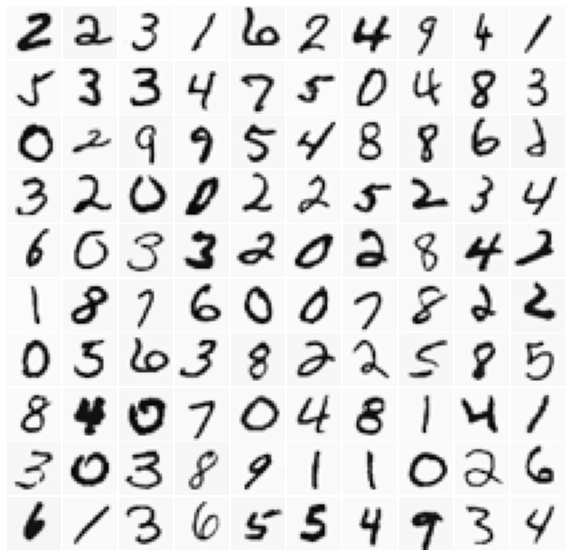

In [17]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

# Multi-class Classification 
***
## Idea behind One-vs-all method
***

### Starting from Logistic Regression 

We have seen in Logistic Regression that we can train a hypothesis a function
$h_\theta(x)$ to give us a probability that our input $x$ is $1$.

$x$ in this case is either 1 or 0 . 

### Using Logistic Regression in our favor (key idea of multi-class classification) 

In our Multi-class Classification case : 
$x$ could be either either 0,1,2,...,9 . 

So training just one hypothesis function, to give us multiple probabilities of x belonging to a class isn't possible. 

Instead what we will do is to train multiple $h_\theta(x)$ functions, each one specialized in recognizing a certain class. 

So to predict that an input x belongs to a class, we will have x as a input to different $h_\theta(x)$ functions and then we gonna see which hypothesis function outputs the biggest probability. x will therefore belong to the the class of that hypothesis function that did output the biggest probability. 

$$\begin{align*}& \newline& \mathrm{prediction} = \max_i( h_\theta ^{(i)}(x) )\newline\end{align*}$$



### Training multiple hypothesis functions 

When training each hypothesis function for a certain class, we gonna label all the other training examples(that does not belong to the class we are to have a hypothesis function for) as $y=0$ and our current class as $y=1$. 

In final we will have for a set of classes the following hypothesis fucntions

$$\begin{align*}& y \in \lbrace0, 1 ... n\rbrace \newline& h_\theta^{(0)}(x) = P(y = 0 | x ; \theta) \newline& h_\theta^{(1)}(x) = P(y = 1 | x ; \theta) \newline& \cdots \newline& h_\theta^{(n)}(x) = P(y = n | x ; \theta) )\newline\end{align*}$$
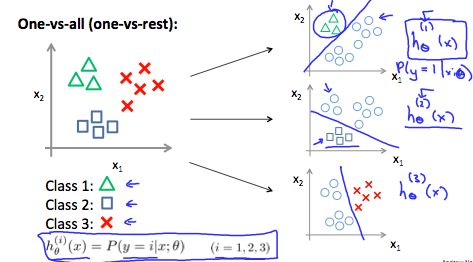

***
## Vectorizing Logistic Regression 
***
Since we will be training 10 different hypothesis functions, we will need to vectorize our Logistic Regression 

### Test values 

In [18]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

### Vectorized Version of the sigmoid function 

In [19]:
def sigmoid(z):
    def sig(x):
         return 1/(1 + np.exp(-x))
    z = np.array(z)
    
    
    vfunc = np.vectorize(sig) 
    
    g = vfunc(z)
    
    return g 

### Vectorizing the cost function J 

Cost function vectorized (regularized) :

$$J(\theta)  = \frac{1}{m} \cdot \left(-y^{T}\log(h)-(1-y)^{T}\log(1-h)\right) + \frac{\lambda }{2m} \theta^{T}\theta$$ 

with : 
$$   \theta = \begin{bmatrix} \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}$$
we need to exclude $ \theta_0 $


As for the gradient of the cost function (non-regularized) : 

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$


In [20]:
def lrCostFunction(theta, X, y, lambda_):
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    '''Calculating the cost function'''
    
    # calculating the hypothesis matrix 
    h = sigmoid(X @ theta)

    log = np.vectorize(np.log)
    
    # calculating the unregularized cost function J 
    J = (-(y.T)@log(h) -((1-y).T)@log(1-h))/m 
    
    # adding the regularization term to the cost function 
    last_sum = (np.dot(theta[1:], theta[1:]))
    last_therm = ((last_sum*(lambda_))/(2*m))
    
    J += last_therm
    
    
    '''Calculating the grad of the cost function'''
    
    # creating a vector with the dimension of the number of the features 
    grad = np.zeros(X.shape[1])
    
    # exclude the regularization term for the theta_0 
    grad[0] = ((X[:,0].T)@(h - y))/m 
    

    grad[1:]= (((X[:,1:].T)@(h - y))/m) + ((lambda_)/m)*theta[1:]
    
    return J, grad

***
## One-vs-all  implementation 
***

In [21]:
def oneVsAll(X, y, num_labels, lambda_):
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for label in range(num_labels): 
        current_y = y.copy()
        
        #seperating the labels, for the training of our current hypothesis function  
        current_y[y == label] = 1 
        current_y[y != label] = 0 
        
        
        #optimizing the cost function 
        initial_theta = np.zeros(n+1)
        options= {'maxiter': 50}

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, current_y, lambda_),
                                jac=True,
                                method='TNC',
                                options=options)
        all_theta[label, :] = res.x
        
        
        
    return all_theta

### Making the prediction 

In [22]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    hypo_matrix = X @ all_theta.T
    all_p = sigmoid(hypo_matrix)
    
    
    # we want the index of hypothesis function which results the biggest probabilty 
    # the index here indicates the label of x
    # axis = 1 means that we want to find the index of the max in every column of matrix 
    p = np.argmax(all_p , axis=1)
    
    return p

# Tests 

## cost function 

In [23]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


## one-vs-all

In [ ]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))